In [1]:
# cd into ws
%cd  /content/drive/MyDrive/mis

/content/drive/MyDrive/mis


In [2]:
!pip install opencv-python matplotlib
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install geojson

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-87d945bw
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-87d945bw
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [ ]:
# Download the default trained model:
# https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [3]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.1.0+cu118
Torchvision version: 0.16.0+cu118
CUDA is available: True


In [4]:
import glob
import cv2
import sys
import matplotlib.pyplot as plt
from preprocessing import preprocess_image
# sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from postprocessing import mask_to_polygon, draw_polygons_on_image, show_annotations, write_polygons_to_geojson

In [5]:
# Import satellite or aerial images from the designated data directory
aerial_images = glob.glob("./data/*")

In [6]:
# Load segment anything (SAM) model
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [7]:
# Segment major features in aerial image
mask_generator_ = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.96,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

image = preprocess_image(aerial_images[0])
masks = mask_generator_.generate(image)

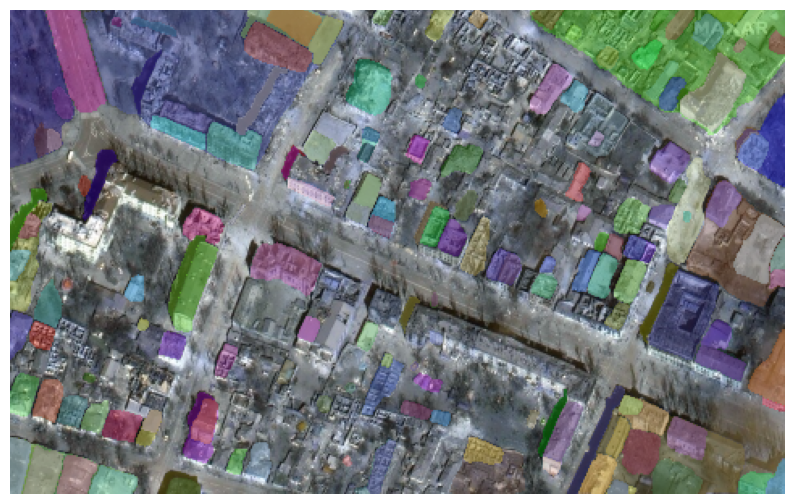

In [8]:
# Show SAM result
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_annotations(masks)
plt.axis('off')
plt.show()

In [9]:
# Get all segmentations and create a polygon list
segmentations = [m["segmentation"] for m in masks]
polygons = []

for seg in segmentations:
    # Convert the mask to a polygon
    polygon = mask_to_polygon(seg)
    if polygon:
        polygons.append(polygon)

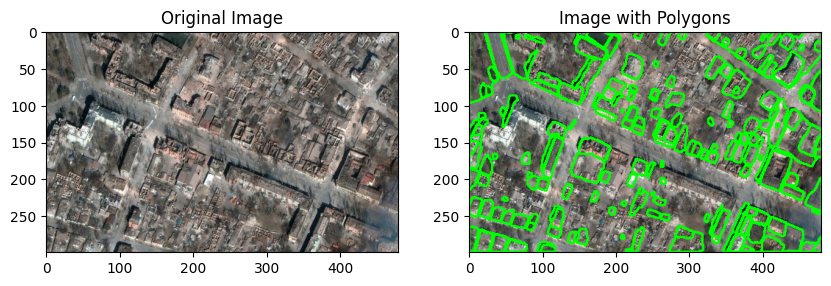

In [10]:
# Draw the polygons on the image
result_image = draw_polygons_on_image(image, polygons)

# Display the original image and the image with the drawn polygons
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
plt.subplot(1, 2, 2), plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)), plt.title('Image with Polygons')
plt.show()

In [11]:
# Specify the output GeoJSON file path
output_geojson_file = "file.geojson"

# Write the list of polygons to the GeoJSON file
write_polygons_to_geojson(polygons, output_geojson_file)